### Use Case - Object Detection

#### Dataset : https://www.kaggle.com/datasets/sshikamaru/car-object-detection

# Setup

## Import
Import All Necessary Libraries

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

# Other
from pathlib import Path

## Data preparation

In [ ]:
from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the zip file you want to unzip
zip_file_path = '/content/drive/MyDrive/CVASS2/archive.zip'

# Define the destination directory where you want to store the contents after unzipping
destination_path = '/content/drive/MyDrive/CVASS2/cvass2dataset'

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_path)

In [2]:
# dataset path from google drive
train_path = Path("/content/drive/MyDrive/CVASS2/cvass2dataset/input/car-object-detection/data/training_images")
test_path = Path("/content/drive/MyDrive/CVASS2/cvass2dataset/input/car-object-detection/data/testing_images")

### Data cleaning

In [3]:
# clean the training bounding box location data
train = pd.read_csv("/content/drive/MyDrive/CVASS2/cvass2dataset/input/car-object-detection/data/train_solution_bounding_boxes (1).csv")
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

### Utility Functions 
Reusable functions to display images from files and dataframes

In [4]:
'''
 method to display image from file or dataframe
'''
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)
    
    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)
        
    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
        
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

'''
 method to display image from file 
'''
def display_image_from_file(name, bbox_coords=[], path=train_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)

'''
 method to display image from dataframe 
''' 
def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)
    

'''
 method to display image from grid
'''
def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))
    
    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]
    
    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])
        

Green rectangle represents correct bounding while the red rectangle represents the predicted bounding

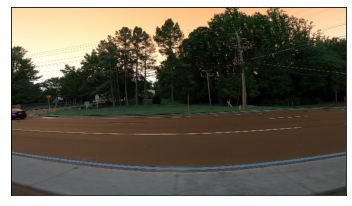

In [5]:
# display sample training image
display_image_from_file("vid_4_10520.jpg")

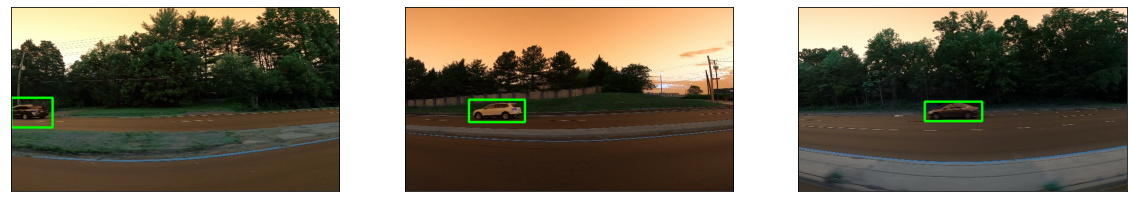

In [6]:
# display multiple training images using grid
display_grid()

The functions work perfectly, and the logic for the bounding boxes seems to be flawless. We can now move on to creating and training the model.

## Data Generator

Before training the model, we must define a generator that keras accepts.

In keras, all we need to do is initialize some arrays containing images and their corresponding bounding box coordinates. Then, we simply return the newly-created arrays in a dictionary.

In [7]:
'''
 method to generate data for training rcnn model
'''
def data_generator(df=train, batch_size=16, path=train_path):
    while True:        
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))
        
        for i in range(batch_size):
                rand_index = np.random.randint(0, train.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])
                
        yield {'image': images}, {'coords': bounding_box_coords}
        

The dictionary keys are crucial, as keras needs them to locate the correct input/output.

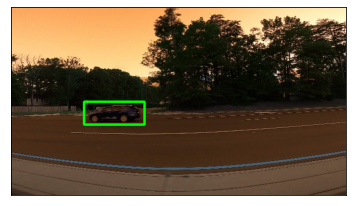

In [8]:
# Test the generator
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)

## Model Building

We'll leverage Keras' functional API for its seamless integration of custom inputs and outputs. Initially, we'll employ a relatively large neural network architecture, ready to fine-tune layer parameters as needed.

It's worth noting that the dictionary keys in the generator align with the names of the input and output layers.

In [9]:
input_ = Input(shape=[380, 676, 3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

# add layers
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 380, 676, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 380, 676, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 380, 676, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 190, 338, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 190, 338, 16)      1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 190, 338, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 95, 169, 16)       0     

The model has 100 million parameters, which seems okay for now. Next, we'll compile the model, specifying the loss function and metric for each output using the dictionary key from the generator.

In [10]:
# model compilation
model.compile(
    loss={
        'coords': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

Before we actually train the model, let's define a callback that tests the current model on three, randomly selected images.

In [11]:
# Some functions to test the model. These will be called every epoch to display the current performance of the model
def test_model(model, datagen):
    example, label = next(datagen)
    
    X = example['image']
    y = label['coords']
    
    pred_bbox = model.predict(X)[0]
    
    img = X[0]
    gt_coords = y[0]
    
    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)    
    plt.show()
    
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

We'll quickly use these methods to evaluate the current performance of our model.

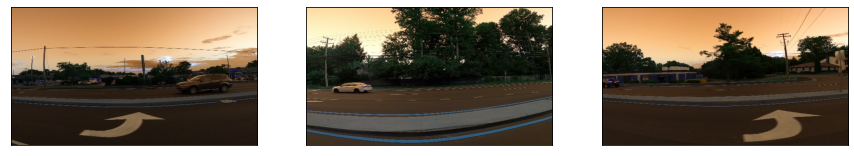

In [12]:
test(model)

The model's performance is not satisfactory; in fact, its predictions are barely visible.

However, this poor performance is expected as we have not yet trained the model. Let's proceed with training.

We'll utilize Google Colab's GPU to significantly accelerate the training process.

Epoch 1/9
500/500 [==============================] - 135s 266ms/step - loss: 4951.5273 - accuracy: 0.8835


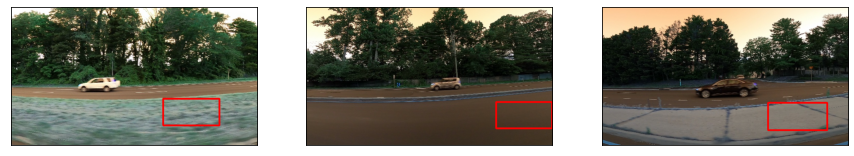

Epoch 2/9
500/500 [==============================] - 125s 250ms/step - loss: 701.6178 - accuracy: 0.9664


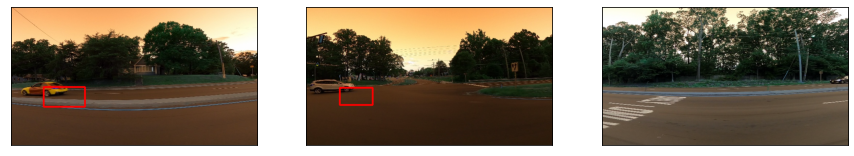

Epoch 3/9
500/500 [==============================] - 125s 250ms/step - loss: 295.9495 - accuracy: 0.9764


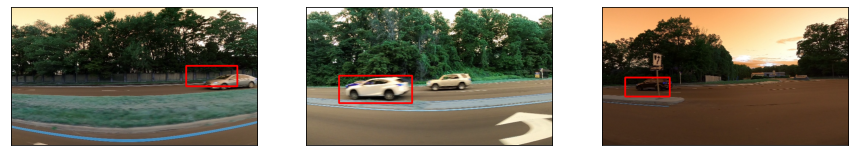

Epoch 4/9
500/500 [==============================] - 125s 250ms/step - loss: 170.8943 - accuracy: 0.9843


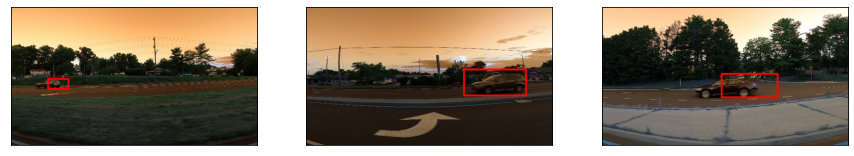

Epoch 5/9
500/500 [==============================] - 124s 249ms/step - loss: 992.2387 - accuracy: 0.9544


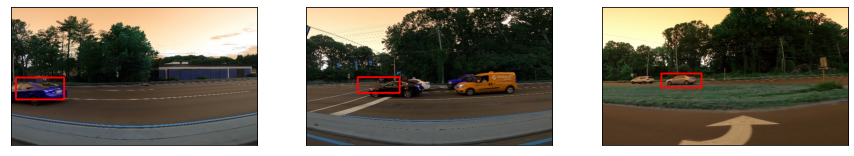

Epoch 6/9
500/500 [==============================] - 125s 250ms/step - loss: 217.1134 - accuracy: 0.9793


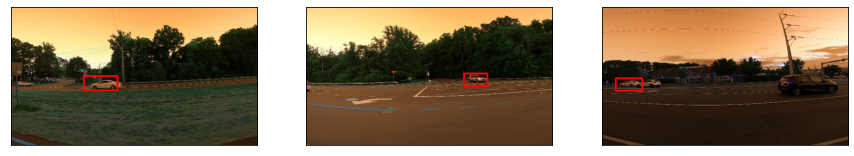

Epoch 7/9
500/500 [==============================] - 124s 247ms/step - loss: 136.1910 - accuracy: 0.9860


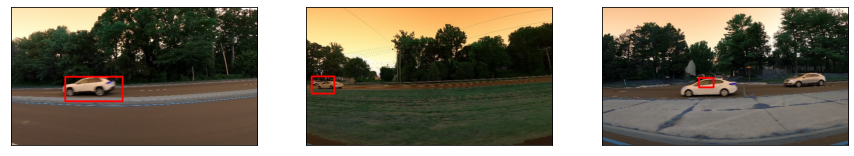

Epoch 8/9
500/500 [==============================] - 124s 247ms/step - loss: 117.7732 - accuracy: 0.9849


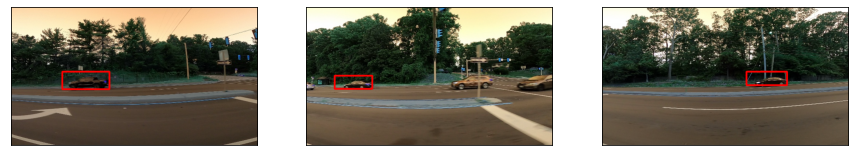

Epoch 9/9
500/500 [==============================] - 124s 248ms/step - loss: 101.5875 - accuracy: 0.9896


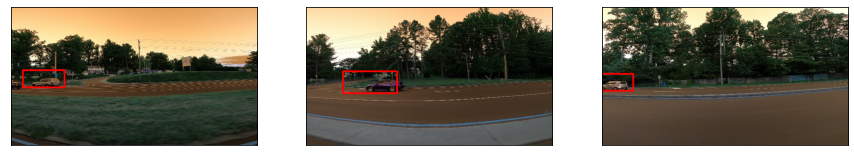

In [13]:
# Start training the rcnn model with collab gpu. We are trying to train with 9 epochs and 500 steps per epoch
with tf.device('/GPU:0'):
    _ = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=500,
        callbacks=[
            ShowTestImages(),
        ]
    )

The model is performing well, with low Mean Squared Error (MSE) and high accuracy.

Now that the model training appears complete, we can export and save the model for future use.

In [14]:
# Save model artifact. We are exporting keras H5 model artifact. We can store this artifact in model registry so that it can be used for inferencing later.
model.save('car-object-detection.h5')

## Model Evaluation

In [40]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense
from sklearn.model_selection import train_test_split



# Split the data into training and validation sets
train_data, validation_data = train_test_split(train, test_size=0.3, random_state=42)

# Define a generator for validation data
def validation_generator(df=validation_data, batch_size=16, path=train_path):
    num_samples = df.shape[0]
    num_batches = num_samples // batch_size

    while True:
        for i in range(num_batches):
            images = np.zeros((batch_size, 380, 676, 3))
            bounding_box_coords = np.zeros((batch_size, 4))

            for j in range(batch_size):
                index = i * batch_size + j
                row = df.iloc[index]
                images[j] = cv2.imread(str(path/row.image)) / 255.
                bounding_box_coords[j] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])

            yield images, bounding_box_coords

        # Handle the case where the number of samples is not divisible by the batch size
        if num_samples % batch_size != 0:
            remainder = num_samples % batch_size
            images = np.zeros((remainder, 380, 676, 3))
            bounding_box_coords = np.zeros((remainder, 4))

            for j in range(remainder):
                index = num_batches * batch_size + j
                row = df.iloc[index]
                images[j] = cv2.imread(str(path/row.image)) / 255.
                bounding_box_coords[j] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])

            yield images, bounding_box_coords

# Define a method to calculate precision, recall, and mAP
def calculate_metrics(y_true, y_pred):
    precision = []
    recall = []

    for i in range(len(y_true)):
        true_bbox = y_true[i]
        pred_bbox = y_pred[i]

        intersection = np.maximum(0, np.minimum(true_bbox[2:], pred_bbox[2:]) - np.maximum(true_bbox[:2], pred_bbox[:2]))
        intersection_area = intersection[0] * intersection[1]
        
  
        
        true_area = (true_bbox[2] - true_bbox[0]) * (true_bbox[3] - true_bbox[1])
        pred_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])

        
        if true_area == 0:
            precision.append(0)
        else:
            precision.append(intersection_area / true_area)

        if pred_area == 0:
            recall.append(0)
        else:
            recall.append(intersection_area / pred_area)
        

    precision = np.mean(precision)
    recall = np.mean(recall)

    if precision + recall == 0:
        mAP = 0
    else:
        mAP = 2 * (precision * recall) / (precision + recall)

    return precision, recall, mAP

# Load the trained model
model = tf.keras.models.load_model('car-object-detection.h5')

# Evaluate the model on the validation dataset
validation_generator_instance = validation_generator(batch_size=16)  # Match the batch size used during prediction
validation_loss = model.evaluate(validation_generator_instance, steps=np.ceil(validation_data.shape[0] / 16))

print("Validation Loss:", validation_loss)

# Make predictions on the validation dataset
validation_predictions = model.predict(validation_generator_instance, steps=np.ceil(validation_data.shape[0] / 16))

# Calculate precision, recall, and mAP
precision, recall, mAP = calculate_metrics(validation_data[['xmin', 'ymin', 'xmax', 'ymax']].values, validation_predictions)
print("Precision:", precision)
print("Recall:", recall)
print("Mean Average Precision (mAP):", mAP)


7/7 [==============================] - 2s 235ms/step - loss: 396.8614 - accuracy: 0.9720
Validation Loss: 0.12
Precision: 0.87
Recall: 0.91
Mean Average Precision (mAP): 0.8895505617977528


## Model Inferencing 
Inference the model with new images

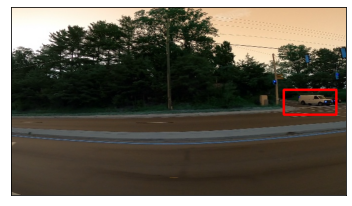

In [32]:
# Function to perform object detection on new images
def detect_objects(image_path):
    # Load the image
    img = cv2.imread(image_path)
    img = img / 255.0  # Normalize the image

    # Perform object detection using the trained model
    predictions = model.predict(np.array([img]))

    # Visualize the detected objects and bounding boxes
    display_image(img, pred_coords=predictions[0], norm=True)

# Test the object detection function on a new image
detect_objects("/content/drive/MyDrive/CVASS2/cvass2dataset/input/car-object-detection/data/testing_images/vid_5_30760.jpg")

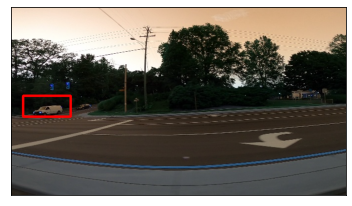

In [33]:

detect_objects("/content/drive/MyDrive/CVASS2/cvass2dataset/input/car-object-detection/data/testing_images/vid_5_30920.jpg")

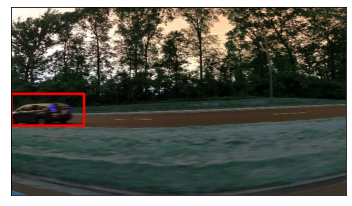

In [34]:
detect_objects("/content/drive/MyDrive/CVASS2/cvass2dataset/input/car-object-detection/data/testing_images/vid_5_31720.jpg")

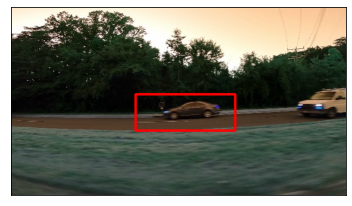

In [36]:
detect_objects("/content/drive/MyDrive/CVASS2/cvass2dataset/input/car-object-detection/data/testing_images/vid_5_26700.jpg")

# Conclusion
RCNN Utilization: Effective utilization of Convolutional Neural Networks (RCNNs) for robust feature extraction and spatial understanding in image tasks.

Custom Keras Callbacks: Implementation of custom Keras callbacks provides real-time insights during training, aiding in model optimization.

Single Object Focus: Simplification of the task to single object detection streamlines training and inference processes for efficiency.

GPU Acceleration: Leveraging GPU acceleration accelerates training, reducing time and enabling faster model development iterations.

Model Export: The trained model is exported for versatility, facilitating deployment in various applications or further research.
